In [18]:
import numpy as np
import pandas as pd
import load_data as ld
import preprocess as pre
from numpy.linalg import norm
import networkx as nx
import operator
from textrank import KeywordSummarizer


def cos_similarity(lst1, lst2):
    return np.dot(lst1, lst2)/(norm(lst1)*norm(lst2))

def rescale(num, maxNum):
    return maxNum*num

def get_top_N(dict, n):
    sorted_dict = sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:n] #sorted(dict, key = dict.get, reverse=True)[:n]
    return sorted_dict

    
    
def get_nodes(title, option="TF", n=10):
    paragraphs = ld.read_txt(title + ".txt")
    if option=="TF":
        tokens_comb = pre.preprocess_node(paragraphs)
        dic_comb = pre.make_dic_count(tokens_comb)
        return get_top_N(dic_comb, n) 
    elif option=="textrank":
        keyword_extractor = KeywordSummarizer(
            tokenize = pre.mecab_tokenize,
            window = -1,
            verbose = False
        )
        dic_comb = []
        sents = " ".join(paragraphs).split(". ")
        keywords = keyword_extractor.summarize(sents, topk=n)
        for word, rank in keywords:
            dic_comb.append((word, rank))
        return dic_comb
            

def get_adj(title, nodes, option, scale):
    
    paragraphs = ld.read_txt(title + ".txt")
    tokens_paras, tokens_stcs = pre.preprocess_edge(paragraphs) 
    dic_paras = list(map(pre.make_dic_count, tokens_paras))
    dic_stcs = list(map(pre.get_stcs_dic, tokens_stcs))
    
    tokens_stcs = sum(tokens_stcs, [])
    dic_stcs = sum(dic_stcs, [])
    
    def get_vector(dictList, keyword):
        vector = []
        for dic in dictList:
            if keyword in dic.keys():
                vector.append(dic[keyword])
            else:
                vector.append(0)
        return vector
    
    N = len(nodes)
    cotable = np.zeros((N, N))
        
    
    for i in range(N):
        for j in range(N):
            if (i!=j):
                left, right = nodes[i][0], nodes[j][0]
                if option == "ss":
                    for stc in tokens_stcs:
                        if left in stc and right in stc:
                            cotable[i][j] += 1        
                elif option == "ps":
                    for para in tokens_paras:
                        if left in para and right in para:
                            cotable[i][j] += 1  
                elif option == "scs":
                    Lvector = get_vector(dic_stcs, left)
                    Rvector = get_vector(dic_stcs, right)
                    cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
                elif option == "pcs":
                    Lvector = get_vector(dic_paras, left)
                    Rvector = get_vector(dic_paras, right)
                    cotable[i][j] = rescale(cos_similarity(Lvector, Rvector), scale)
                else:
                    print("error : choose option among ('ss', 'ps', 'scs', 'pcs')")
    if option == "ss" or "ps":
        maxvalue = np.max(cotable)
        cotable = rescale(cotable / maxvalue, scale)
    return cotable

In [26]:
title = "바이오"
scale = 7
num_node = 10
option = "ss"
img_name = title + '_' + option + '_' + str(num_node)
nodes = get_nodes(title, "TF", num_node)
adj = get_adj(title, nodes, option, scale)

In [27]:
adj

array([[0.        , 7.        , 4.11764706, 4.11764706, 1.64705882,
        2.88235294, 2.05882353, 3.29411765, 0.82352941, 2.05882353],
       [7.        , 0.        , 4.11764706, 2.47058824, 2.05882353,
        2.47058824, 2.47058824, 2.47058824, 0.82352941, 1.23529412],
       [4.11764706, 4.11764706, 0.        , 2.88235294, 3.70588235,
        2.05882353, 1.23529412, 2.05882353, 2.47058824, 2.05882353],
       [4.11764706, 2.47058824, 2.88235294, 0.        , 1.23529412,
        1.23529412, 0.82352941, 2.47058824, 0.82352941, 2.05882353],
       [1.64705882, 2.05882353, 3.70588235, 1.23529412, 0.        ,
        0.82352941, 0.82352941, 0.41176471, 0.82352941, 0.41176471],
       [2.88235294, 2.47058824, 2.05882353, 1.23529412, 0.82352941,
        0.        , 2.05882353, 1.23529412, 0.82352941, 1.64705882],
       [2.05882353, 2.47058824, 1.23529412, 0.82352941, 0.82352941,
        2.05882353, 0.        , 0.82352941, 0.82352941, 0.41176471],
       [3.29411765, 2.47058824, 2.0588235

In [3]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

path = 'C:\\WINDOWS\\Fonts\\malgunbd.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_name)

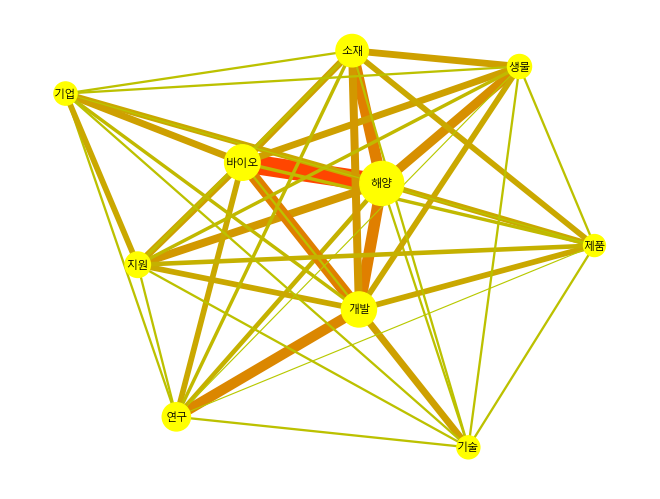

In [24]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

G = nx.Graph()
weighted_edges = []
attr_nodes = []
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if(i!=j and adj[i][j] != 0):
            G.add_edge(nodes[i][0], nodes[j][0], weight=adj[i][j])
    attr_nodes.append((nodes[i]))#(i, {'name':nodes[i]}))
 
weights = nx.get_edge_attributes(G, "weight")
edges = G.edges()
nodeSize = [ t[1] for t in nodes ]
nodeSize = nodeSize / np.max(nodeSize) * 1000 

scaling_factor = 2 # to emphasise differences 
alphas = [(weights[edge]) * scaling_factor for edge in edges]
colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
nx.draw_spring(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)